### ====================================================
### Evaluation and Error Analysis
#### Analyze the performance of the fine-tuned RoBERTa model.
#### ====================================================


In [1]:

# Libraries 
import os
import numpy as np
import pandas as pd
import torch
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import Dataset
from scipy.special import softmax


torch.manual_seed(42)
np.random.seed(42)

# Model
MODEL_NAME = "roberta-base"

# Paths
path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
os.chdir(path)

# Tokenizer
tokenized_dir = f"{path}/tokenized/text/{MODEL_NAME.replace('/', '_')}_maxlen105"

# Fine-tuned model directory
finetuned_dir = "./models/text/roberta_finetuned"


c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Model, Tokenizer and Test Dataset
tokenizer = AutoTokenizer.from_pretrained(finetuned_dir)
model = AutoModelForSequenceClassification.from_pretrained(finetuned_dir)
print(f"Model and tokenizer loaded from: {finetuned_dir}")

Model and tokenizer loaded from: ./models/text/roberta_finetuned


In [3]:
# Load Tokenized Test Dataset 
test_dataset_tok = Dataset.load_from_disk(os.path.join(tokenized_dir, "test"))
print(f"Tokenized test dataset loaded from: {os.path.join(tokenized_dir, 'test')}")

Tokenized test dataset loaded from: C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining/tokenized/text/roberta-base_maxlen105\test


In [4]:
# Evaluate model on test set
trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(test_dataset_tok)

#Predictions
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


#Confidence
logits = predictions.predictions 
probs = softmax(logits, axis=1) 
pred_confidence = probs.max(axis=1) 

#We add it to our test dataset
df_test = test_dataset_tok.to_pandas()
df_test["pred_label"] = y_pred
df_test["predicted_label"] = df_test["pred_label"].map({0: "oppose", 1: "support"})
df_test["predicted_confidence"] = pred_confidence
df_test.head()

C:\Users\diego\AppData\Local\Temp\ipykernel_23864\1995192885.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)
c:\Users\diego\anaconda3\envs\multimodal\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,tweet_text,label,input_ids,attention_mask,pred_label,predicted_label,predicted_confidence
0,LAUNCH of our mobile billboards as part of our...,0,"[0, 8272, 25311, 9, 84, 1830, 30792, 25, 233, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,support,0.993108
1,"Yesterday, the Supreme Court of the United Sta...",0,"[0, 31863, 6, 5, 2124, 837, 9, 5, 315, 532, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,support,0.988165
2,Abortion at home is safe and effective. We kno...,1,"[0, 13112, 33938, 23, 184, 16, 1522, 8, 2375, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,support,0.692046
3,Is Abortion in Israel Holding Back Moshiach? T...,0,"[0, 6209, 38472, 11, 1870, 11549, 3727, 256, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,support,0.940136
4,"“KS want limits on the abortion industry, Valu...",0,"[0, 17, 48, 18307, 236, 4971, 15, 5, 6428, 539...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,support,0.971162


In [5]:
# Metrics
acc = accuracy_score(y_true, y_pred)
prec, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print("Evaluation Metrics on Test Set: ")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=["oppose", "support"]))


Evaluation Metrics on Test Set: 
Accuracy:  0.5900
Precision: 0.7280
Recall:    0.5900
F1-Score:  0.5700

Detailed Classification Report:
              precision    recall  f1-score   support

      oppose       0.88      0.37      0.53       182
     support       0.49      0.92      0.64       118

    accuracy                           0.59       300
   macro avg       0.69      0.65      0.58       300
weighted avg       0.73      0.59      0.57       300



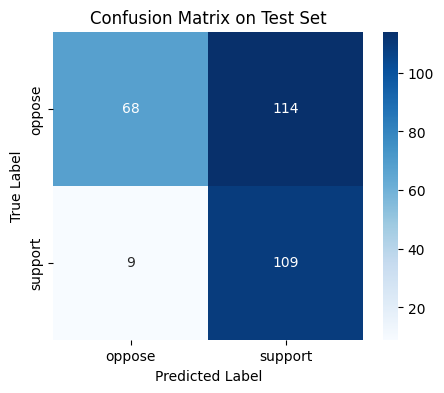

In [6]:
# Confusion Matrix
labels = ["oppose", "support"]
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [7]:
#Misclassifications
df_test["stance"] = df_test["label"].map({0: "oppose", 1: "support"})
df_errors = df_test[df_test["label"] != df_test["pred_label"]].copy()
print(f"Misclassified samples: {len(df_errors)} / {len(df_test)}")

# Some Examples
df_errors[["tweet_text","stance","label","pred_label"]].head()

Misclassified samples: 123 / 300


,tweet_text,stance,label,pred_label
0,LAUNCH of our mobile billboards as part of our...,oppose,0,1
1,"Yesterday, the Supreme Court of the United Sta...",oppose,0,1
3,Is Abortion in Israel Holding Back Moshiach? T...,oppose,0,1
4,"“KS want limits on the abortion industry, Valu...",oppose,0,1
5,Adoption Is A Loving Option #heartbeatofmiami ...,oppose,0,1


## Error Analysis

### Feature Extraction

In [9]:
#Extract linguistic and social media features from tweets
def extract_tweet_features(text: str):
    features = {
        'has_hashtag': bool(re.search(r'#\w+', text)),
        'hashtag_count': len(re.findall(r'#\w+', text)),
        'hashtags': re.findall(r'#(\w+)', text),
        'has_mention': bool(re.search(r'@\w+', text)),
        'mention_count': len(re.findall(r'@\w+', text)),
        'has_url': bool(re.search(r'http[s]?://|www\.', text)),
        'has_emoji': bool(re.search(r'[😀-🙏🌀-🗿🚀-🛿]', text)),
        'char_count': len(text),
        'word_count': len(text.split()),
        'has_question': '?' in text,
        'has_exclamation': '!' in text,
        'is_uppercase': text.isupper() if text else False,
        'capitalized_words': len([w for w in text.split() if w.isupper() and len(w) > 1])
    }
    return features

# We Analyze features in errors (predictions)
def analyze_features_in_errors(df_test: pd.DataFrame):
    df = df_test.copy()
    df['is_error'] = df['stance'] != df['predicted_label']  
    df_errors = df[df['is_error']]
    features_list = df_errors['tweet_text'].apply(extract_tweet_features)
    features_df = pd.DataFrame(features_list.tolist())
    df_errors = pd.concat([df_errors.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)
    
  
    total_errors = len(df_errors)  
    print(f"\nTotal misclassified tweets: {total_errors}\n")
    
    # Boolean features (% of errors having this feature)
    boolean_features = ['has_hashtag', 'has_mention', 'has_url', 'has_emoji',
                        'has_question', 'has_exclamation', 'is_uppercase']
    
    print("---> Boolean Features (% of errors):")
    for feature in boolean_features:
        count = df_errors[feature].sum()
        pct = (count / total_errors * 100) if total_errors else 0
        print(f"    •{feature.replace('_',' ').title()}: {count} tweets ({pct:.1f}%)")
    
    # Numeric features (average values in misclassified tweets)
    numeric_features = ['hashtag_count', 'mention_count', 'char_count', 'word_count', 'capitalized_words']
    
    print("\n---> Numeric Features (average in misclassified tweets):")
    for feature in numeric_features:
        mean_val = df_errors[feature].mean() if total_errors else 0
        print(f"    •{feature.replace('_',' ').title()}: {mean_val:.2f}")

analyze_features_in_errors(df_test)



Total misclassified tweets: 123

---> Boolean Features (% of errors):
    •Has Hashtag: 86 tweets (69.9%)
    •Has Mention: 29 tweets (23.6%)
    •Has Url: 0 tweets (0.0%)
    •Has Emoji: 7 tweets (5.7%)
    •Has Question: 15 tweets (12.2%)
    •Has Exclamation: 17 tweets (13.8%)
    •Is Uppercase: 0 tweets (0.0%)

---> Numeric Features (average in misclassified tweets):
    •Hashtag Count: 1.97
    •Mention Count: 0.38
    •Char Count: 206.80
    •Word Count: 32.66
    •Capitalized Words: 0.71


### Confidently Wrong Predictions

In [ ]:
# Confidently wrong predictions summary
def summarize_confidently_wrong(df_test: pd.DataFrame, confidence_threshold: float = 0.9, top_n: int = 20):

    df = df_test.copy()
    df['is_error'] = df['stance'] != df['predicted_label']
    
    # Filter confident wrong predictions
    confident_wrong = df[(df['is_error']) & (df['predicted_confidence'] >= confidence_threshold)].copy()
    total_confident = len(confident_wrong)
    

    # Extract features
    features_list = confident_wrong['tweet_text'].apply(extract_tweet_features)
    features_df = pd.DataFrame(features_list.tolist())
    confident_wrong = pd.concat([confident_wrong.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)
    
    print(f"--> Confidently Wrong Predictions (Conf >= {confidence_threshold})")
    print(f"Total confidently wrong: {total_confident}")
    
    # Show Top - N Cases
    print(f"Top {min(top_n, total_confident)} cases:\n")
    
    for idx, row in confident_wrong.head(top_n).iterrows():
        true_label = row["stance"]
        pred_label = row["predicted_label"]

        print(f"\n❌ Conf: {row['predicted_confidence']:.4f} | True: {true_label} | Pred: {pred_label}")
        print(f"  Tweet: {row['tweet_text']}") 
        
        # We add Hashtags
        if row['has_hashtag']:
            hashtags_str = ', '.join(['#'+h for h in row['hashtags']])
            print(f"Hashtags: {hashtags_str}")
        
        # We add Mentions
        if row['has_mention']:
            mentions_str = ', '.join(['@'+m for m in re.findall(r'@(\w+)', row['tweet_text'])])
            print(f"Mentions: {mentions_str}")

        if row['has_emoji']:
            print("Contains Emojis")

#We Run the Analysis
summarize_confidently_wrong(df_test, confidence_threshold=0.9, top_n=20)


--> Confidently Wrong Predictions (Conf >= 0.9)
Total confidently wrong: 89
Top 20 cases:


❌ Conf: 0.9931 | True: oppose | Pred: support
  Tweet: LAUNCH of our mobile billboards as part of our 'Vote for Life' Campaign. As pro-life citizens, we cannot vote for any candidate who supports abortion - the killing of innocent preborn children. TOMORROW, make your vote count by voting pro-life! #voteforlife #repealsection9
Hashtags: #voteforlife, #repealsection9

❌ Conf: 0.9882 | True: oppose | Pred: support
  Tweet: Yesterday, the Supreme Court of the United States allowed for mail-order delivery of the abortion pill. Not only does this threaten unborn lives, but also the lives of women. Read more: #BestforChildren #ProLife
Hashtags: #BestforChildren, #ProLife

❌ Conf: 0.9401 | True: oppose | Pred: support
  Tweet: Is Abortion in Israel Holding Back Moshiach? The 40,000 a year abortion free-for-all in Israel is horrifying, shameful, and devastating. Please contact us if you can volunteer to

In [11]:
# Save predictions to disk for later analysis
results_dir = os.path.join(path, "results")
os.makedirs(results_dir, exist_ok=True)
df_test.to_csv(os.path.join(results_dir, "test_predictions_with_confidence.csv"), index=False)
print(f"\nSaved test predictions (with confidence) to: {results_dir}/test_predictions_with_confidence.csv")


Saved test predictions (with confidence) to: C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining\results/test_predictions_with_confidence.csv
